# Clustering & Demographics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

Here we import the demographic sheet of the dataset, rename its columns and display it pretty (we drop native.. and asian.. because we don't have the required data for these categories)

In [2]:
# Assuming demo_df is already loaded and demo_df_long is created as before
demo_df = pd.read_excel("Count_by_demo.xlsx")

# Identify the index of the first occurrence of "Any Opioid1" or similar categories
end_index = demo_df[demo_df['Year'].str.contains("Any Opioid", na=False)].index.min()

# Filter the DataFrame to keep only rows before the identified index, ensuring we only have total deaths
demo_df_filtered = demo_df.loc[:end_index-1].copy()

positions_to_drop = range(9, 15)  # This will drop rows 9, 10, 11, 12, 13, and 14
df_dropped = demo_df_filtered.drop(demo_df_filtered.iloc[positions_to_drop].index).reset_index(drop=True)

# Convert the filtered dataset to a long format
demo_df_long_filtered = pd.melt(df_dropped, id_vars=['Year'], var_name='Year_Num', value_name='Death_Count')

# Filter out rows for 'Fold Change 2015 to 2021' and ensure 'Year_Num' is numeric, handling warnings properly
demo_df_long_filtered = demo_df_long_filtered[demo_df_long_filtered['Year_Num'].apply(lambda x: str(x).isnumeric())].copy()
demo_df_long_filtered['Year_Num'] = demo_df_long_filtered['Year_Num'].astype(int)

# Convert 'Death_Count' to numeric, handling non-numeric values properly
demo_df_long_filtered['Death_Count'] = pd.to_numeric(demo_df_long_filtered['Death_Count'], errors='coerce')
demo_df_long_filtered.dropna(subset=['Death_Count'], inplace=True)

demo_df_long_filtered.rename(columns={'Year': 'Demographic Characteristic', 'Year_Num': 'Year'}, inplace=True)

print(demo_df_long_filtered)

                            Demographic Characteristic  Year  Death_Count
0                                Total Overdose Deaths  1999          6.1
1                                               Female  1999          3.9
2                                                 Male  1999          8.2
3                                 White (Non-Hispanic)  1999          6.2
4                                               Female  1999          4.3
..                                                 ...   ...          ...
340                                             Female  2021          9.4
341                                               Male  2021         32.4
342    American Indian or Alaska Native (Non-Hispanic)  2021         56.5
343                                             Female  2021         44.1
344                                               Male  2021         69.3

[345 rows x 3 columns]


Then, we create another data frame in which we only keep the rows with indexes = multipliers of 3 **(the ethnicity)**

In [3]:
ethnicity_df = demo_df_long_filtered.loc[demo_df_long_filtered.index % 3 == 0].reset_index(drop=True)
display(ethnicity_df)

,Demographic Characteristic,Year,Death_Count
0,Total Overdose Deaths,1999,6.1
1,White (Non-Hispanic),1999,6.2
2,Black (Non-Hispanic),1999,7.5
3,Hispanic,1999,5.4
4,American Indian or Alaska Native (Non-Hispanic),1999,6.0
...,...,...,...
110,Total Overdose Deaths,2021,32.4
111,White (Non-Hispanic),2021,36.8
112,Black (Non-Hispanic),2021,44.2
113,Hispanic,2021,21.1


Now we clean the DF again and only display specific values, not the total overdose deaths of that year by dropping every row that has the keyword "total" in it.

In [4]:
ethnicity_df_cleaned = ethnicity_df[~ethnicity_df['Demographic Characteristic'].str.contains('total', case=False)].reset_index(drop=True)

# Display the first few rows of the cleaned dataframe
display(ethnicity_df_cleaned)

,Demographic Characteristic,Year,Death_Count
0,White (Non-Hispanic),1999,6.2
1,Black (Non-Hispanic),1999,7.5
2,Hispanic,1999,5.4
3,American Indian or Alaska Native (Non-Hispanic),1999,6.0
4,White (Non-Hispanic),2000,6.6
...,...,...,...
87,American Indian or Alaska Native (Non-Hispanic),2020,42.5
88,White (Non-Hispanic),2021,36.8
89,Black (Non-Hispanic),2021,44.2
90,Hispanic,2021,21.1


We create a list with the demographic characteristics at the rows which are multipliers of 3, so we can later append them as a prefix to subcategories Male and Female, so as not to lose the logic of the table 

In [5]:
values_at_multiples_of_three = []  # Initialize an empty list to store the values

# Iterate over the DataFrame index
for index in demo_df_long_filtered.index:
    if index % 3 == 0:  # Check if the index is a multiple of 3
        # Append the 'Demographic Characteristic' value at this index to the list
        values_at_multiples_of_three.append(demo_df_long_filtered.loc[index, 'Demographic Characteristic'])
        
cleaned_values_at_multiples_of_three = [re.sub(r'\xa0', ' ', value).strip() for value in values_at_multiples_of_three]
print(cleaned_values_at_multiples_of_three)

['Total Overdose Deaths', 'White (Non-Hispanic)', 'Black (Non-Hispanic)', 'Hispanic', 'American Indian or Alaska Native (Non-Hispanic)', 'Total Overdose Deaths', 'White (Non-Hispanic)', 'Black (Non-Hispanic)', 'Hispanic', 'American Indian or Alaska Native (Non-Hispanic)', 'Total Overdose Deaths', 'White (Non-Hispanic)', 'Black (Non-Hispanic)', 'Hispanic', 'American Indian or Alaska Native (Non-Hispanic)', 'Total Overdose Deaths', 'White (Non-Hispanic)', 'Black (Non-Hispanic)', 'Hispanic', 'American Indian or Alaska Native (Non-Hispanic)', 'Total Overdose Deaths', 'White (Non-Hispanic)', 'Black (Non-Hispanic)', 'Hispanic', 'American Indian or Alaska Native (Non-Hispanic)', 'Total Overdose Deaths', 'White (Non-Hispanic)', 'Black (Non-Hispanic)', 'Hispanic', 'American Indian or Alaska Native (Non-Hispanic)', 'Total Overdose Deaths', 'White (Non-Hispanic)', 'Black (Non-Hispanic)', 'Hispanic', 'American Indian or Alaska Native (Non-Hispanic)', 'Total Overdose Deaths', 'White (Non-Hispanic)'

Appending and visualising final table:

In [6]:
# Aggregate ethnicity and gender
pointer_list = 0
for index in demo_df_long_filtered.index:
    if index % 3 == 1:  # Rows 1, 4, 7, etc.
        demo_df_long_filtered.at[index, 'Demographic Characteristic'] = cleaned_values_at_multiples_of_three[pointer_list] + ' ' + demo_df_long_filtered.at[index, 'Demographic Characteristic']
    elif index % 3 == 2:  # Rows 2, 5, 8, etc.
        demo_df_long_filtered.at[index, 'Demographic Characteristic'] = cleaned_values_at_multiples_of_three[pointer_list] + ' ' + demo_df_long_filtered.at[index, 'Demographic Characteristic']
        pointer_list += 1
    if pointer_list >= len(cleaned_values_at_multiples_of_three):
        break  # Exit the loop if there are no more characteristics to append.

demo_df_long_filtered = demo_df_long_filtered[demo_df_long_filtered.index % 3 != 0].reset_index(drop=True)

# Display the first few rows to verify
print(demo_df_long_filtered)
demo_df_long_filtered.to_csv(r"C:\Users\mirun\Downloads\products333.csv", index=False)

                            Demographic Characteristic  Year  Death_Count
0                       Total Overdose Deaths   Female  1999          3.9
1                         Total Overdose Deaths   Male  1999          8.2
2                    White (Non-Hispanic)       Female  1999          4.3
3                      White (Non-Hispanic)       Male  1999          8.0
4                    Black (Non-Hispanic)       Female  1999          4.0
..                                                 ...   ...          ...
225                    Black (Non-Hispanic)       Male  2021         67.3
226                              Hispanic       Female  2021          9.4
227                                Hispanic       Male  2021         32.4
228  American Indian or Alaska Native (Non-Hispanic...  2021         44.1
229  American Indian or Alaska Native (Non-Hispanic...  2021         69.3

[230 rows x 3 columns]


Do the same cleaning process for the gender data frame

In [7]:
gender_df_cleaned = demo_df_long_filtered[~demo_df_long_filtered['Demographic Characteristic'].str.contains('total', case=False)].reset_index(drop=True)
display(gender_df_cleaned)

,Demographic Characteristic,Year,Death_Count
0,White (Non-Hispanic) Female,1999,4.3
1,White (Non-Hispanic) Male,1999,8.0
2,Black (Non-Hispanic) Female,1999,4.0
3,Black (Non-Hispanic) Male,1999,11.5
4,Hispanic Female,1999,2.2
...,...,...,...
179,Black (Non-Hispanic) Male,2021,67.3
180,Hispanic Female,2021,9.4
181,Hispanic Male,2021,32.4
182,American Indian or Alaska Native (Non-Hispanic...,2021,44.1


Plot the elbow method to find the optimal k value

C:\Users\mirun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


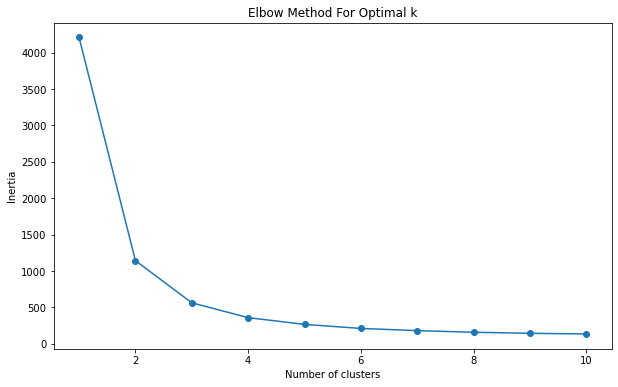

In [8]:
# Step 1: Preprocessing the Data
# One-hot encode the 'Demographic Characteristic' column
onehot_encoder = OneHotEncoder(sparse=False)
demographic_encoded = onehot_encoder.fit_transform(ethnicity_df_cleaned[['Demographic Characteristic']])

# Scale the 'Death_Count' column
scaler = StandardScaler()
death_count_scaled = scaler.fit_transform(ethnicity_df_cleaned[['Death_Count']])

# No need to scale the 'Year' column as it's already in a numerical format and we're treating it as a continuous variable.

# Combine the encoded demographics and the scaled death counts into one dataframe for clustering
X_clustering = pd.concat([
    pd.DataFrame(demographic_encoded, columns=onehot_encoder.get_feature_names_out()),
    pd.DataFrame(death_count_scaled, columns=['Death_Count']),
    ethnicity_df_cleaned['Year']  # Adding the year as a numerical feature
], axis=1)

# Step 2: Determine the Number of Clusters
# Use the elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

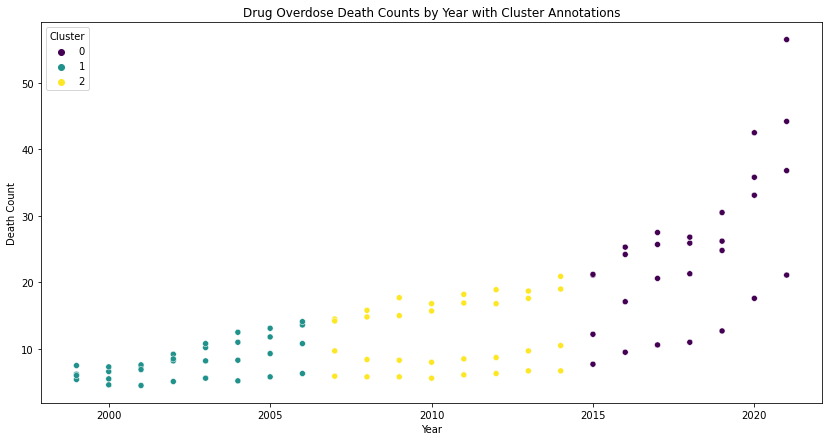

In [9]:
# Performing K-Means clustering with 3 clusters based on the elbow plot
kmeans = KMeans(n_clusters=3, random_state=42)
ethnicity_df_cleaned['Cluster'] = kmeans.fit_predict(X_clustering)

# Adding the cluster labels to the original dataframe for interpretation
ethnicity_df_cleaned['Cluster'] = kmeans.labels_

# Visualizing the clusters with respect to the original features
# Since we have encoded categorical features, direct visualization is not straightforward.
# We will use the Year and Death_Count for visualization and annotate the points with the cluster number.

plt.figure(figsize=(14, 7))
sns.scatterplot(data=ethnicity_df_cleaned, x='Year', y='Death_Count', hue='Cluster', palette='viridis')
plt.title('Drug Overdose Death Counts by Year with Cluster Annotations')
plt.xlabel('Year')
plt.ylabel('Death Count')
plt.legend(title='Cluster')
plt.show()

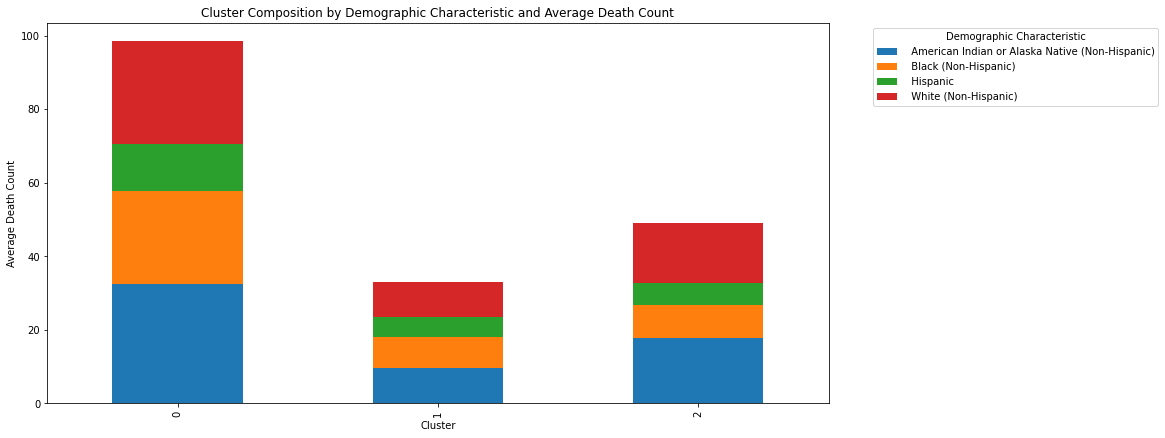

In [10]:
# Composition of the clusters.
# This involves aggregating the data by cluster and demographic characteristic.
cluster_composition = ethnicity_df_cleaned.groupby(['Cluster', 'Demographic Characteristic'])['Death_Count'].mean().unstack(fill_value=0)
cluster_composition.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Cluster Composition by Demographic Characteristic and Average Death Count')
plt.xlabel('Cluster')
plt.ylabel('Average Death Count')
plt.legend(title='Demographic Characteristic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

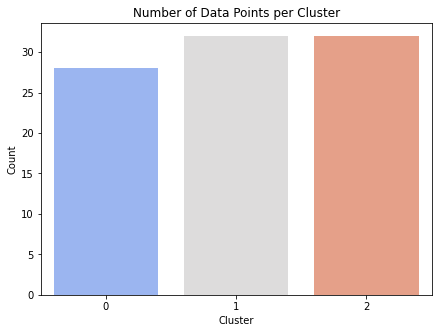

In [11]:
# We can also look at the number of data points per cluster
plt.figure(figsize=(7, 5))
sns.countplot(x='Cluster', data=ethnicity_df_cleaned, palette='coolwarm')
plt.title('Number of Data Points per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

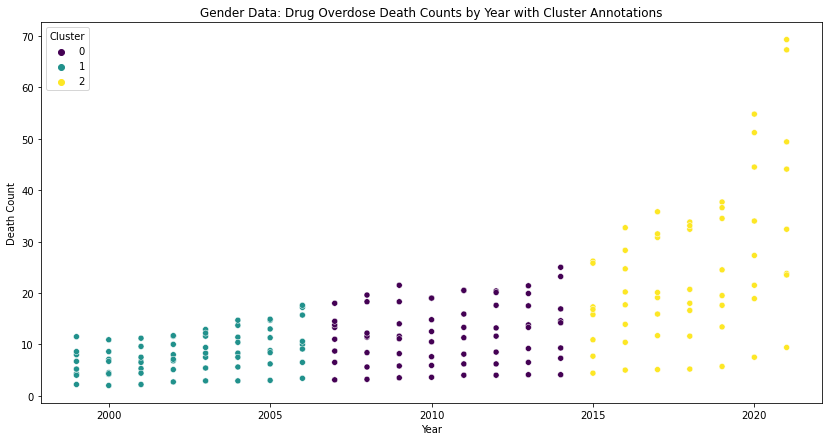

In [12]:
# Preprocessing the Gender Data
# One-hot encode the 'Demographic Characteristic' column with a focus on Male/Female
# Using a custom transformer to extract gender from the demographic characteristic
def extract_gender(demographics):
    return pd.Series(demographics).str.contains('Male').astype(int).replace({0: 'Female', 1: 'Male'})

gender_encoded = extract_gender(gender_df_cleaned['Demographic Characteristic'])

# OneHotEncoding the gender
encoder = OneHotEncoder(sparse=False)
gender_encoded = encoder.fit_transform(gender_encoded.values.reshape(-1, 1))

# Standardize the 'Death_Count' feature
death_count_scaled = scaler.fit_transform(gender_df_cleaned[['Death_Count']])

# Combine the encoded gender and the scaled death counts into one dataframe for clustering
X_clustering_gender = pd.concat([
    pd.DataFrame(gender_encoded, columns=encoder.get_feature_names_out()),
    pd.DataFrame(death_count_scaled, columns=['Death_Count']),
    gender_df_cleaned['Year']  # Adding the year as a numerical feature
], axis=1)

# Applying K-Means clustering with 3 clusters
kmeans_gender = KMeans(n_clusters=3, random_state=42)
gender_df_cleaned['Cluster'] = kmeans_gender.fit_predict(X_clustering_gender)

# Visualization of clusters
# Scatter plot of Death_Count by Year, colored by clusters
plt.figure(figsize=(14, 7))
sns.scatterplot(data=gender_df_cleaned, x='Year', y='Death_Count', hue='Cluster', palette='viridis')
plt.title('Gender Data: Drug Overdose Death Counts by Year with Cluster Annotations')
plt.xlabel('Year')
plt.ylabel('Death Count')
plt.legend(title='Cluster')
plt.show()

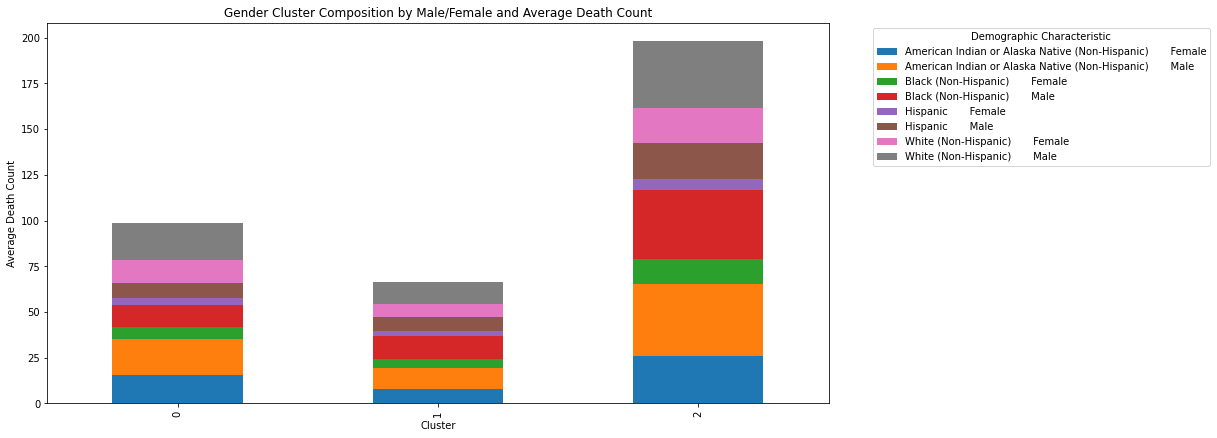

In [13]:
# Stacked bar chart for gender composition within each cluster
cluster_composition_gender = gender_df_cleaned.groupby(['Cluster', 'Demographic Characteristic'])['Death_Count'].mean().unstack(fill_value=0)
cluster_composition_gender = cluster_composition_gender.loc[:, cluster_composition_gender.columns.str.contains('Male|Female')]
cluster_composition_gender.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Gender Cluster Composition by Male/Female and Average Death Count')
plt.xlabel('Cluster')
plt.ylabel('Average Death Count')
plt.legend(title='Demographic Characteristic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

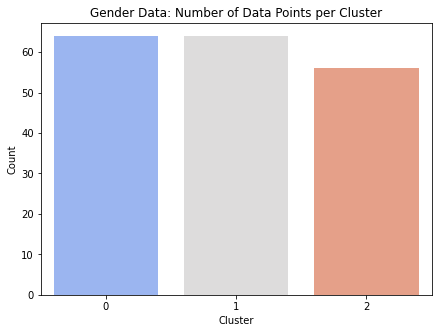

In [14]:
# Count of data points per cluster
plt.figure(figsize=(7, 5))
sns.countplot(x='Cluster', data=gender_df_cleaned, palette='coolwarm')
plt.title('Gender Data: Number of Data Points per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()